# Classify charities into ICNP/TSO categories

Comparison of machine learning models to get the greatest accuracy.

This script runs a number of machine learning models against the manually created sample to determine the best way to produce a classification model that can be run against the full dataset.

The models are created using [scikit-learn](https://scikit-learn.org/stable/index.html).

## Import packages

- `pandas` is used to manipulate the data
- `sklearn.train_test_split` is used to split the sample data
- `nltk` provides functions for preparing the data, plus a list of common stopwords

In [1]:
import re

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\drkan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\drkan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Fetch the sample data

Remove any records which don't have a ICNPTSO category included.

In [32]:
df = pd.concat([
    pd.read_csv("../data/sample.csv"),
    pd.read_csv("../data/top2000.csv"),
]).reset_index()
df = df[df["ICNPTSO"].notnull()]

## Prepare the training data

Create the text corpus by combining the name and activities data. `y` is the ICNPTSO code attached to the charity.

In [33]:
corpus = pd.DataFrame([df["name"], df["activities"]]).T.apply(lambda x: " ".join(x), axis=1)
y = df["ICNPTSO"].values
len(y)

6203

Prepare functions used to clean the text data before it's included in the machine learning models. 

[Lemmatization](https://en.wikipedia.org/wiki/Lemmatisation) is the process where words are turned into the base for of the word - for example "walking" becomes "walk", "better" becomes "good".

Stopwords (common words like "and", "for", "of") are skipped.

In [34]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english') + [
    "trust",
    "fund",
    "charitable",
    "charity",
])

stemmer = LancasterStemmer()
lemma = WordNetLemmatizer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

def lemma_words(doc):
    return (lemma.lemmatize(w) for w in analyzer(doc))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(lemma.lemmatize(word) for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

`X` is the list of cleaned values.

In [35]:
X = corpus.apply(clean_text).values
np.random.choice(X, 1)

array(['lifeline project subject insolvency proceeding object company established object relieve poverty sickness distress among person affected suffer 311 addiction drug kind 312 poor mental emotional physical health 313 obesity 314 sexually transmitted disease including without limitation hiv aid 32 educate public matter relating prevention effective management treatment drug misuse poor mental emotional physical health obesity sexually transmitted disease 33 support assist individual rehabilitation offending view preventing reducing risk crime'],
      dtype=object)

Produce test and train datasets from `X` and `y`.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
len(X_test)

1241

## Test classification models

First import the models we're going to use.

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

Initialise the classifiers.

In [38]:
classifiers = {
      "Naive Bayesian": MultinomialNB(),
      "Linear model - Stochastic gradient descent": SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None),
      "Logistic Regression": LogisticRegression(n_jobs=1, C=1e5),
      "Linear Support Vector Classification": LinearSVC(),
      "Support Vector Classification": SVC(),
#       "Nu-Support Vector Classification": NuSVC(),
      "Decision Tree": DecisionTreeClassifier(max_depth=5),
      "Random Forest": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
#       "MLP Neural Network": MLPClassifier(alpha=1, max_iter=1000),
      "Ada Boost": AdaBoostClassifier(),
}

For each classifier:

 - create the pipeline
 - fit the data
 - predict the values for the test dataset
 - get the accuracy score for the test dataset
 - add the results to the classification report

In [39]:
accuracy = {}
category_results = {}
for name, clf in classifiers.items():
    nb = Pipeline([
                 ('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('clf', clf),
              ])
    nb.fit(X_train, y_train)

    y_pred = nb.predict(X_test)

    print(name)
    accuracy[name] = accuracy_score(y_pred, y_test)
    category_results[name] = pd.DataFrame(
        classification_report(
            y_test,
            y_pred,
            output_dict=True,
            zero_division=0,
        )
    ).T

accuracy = pd.Series(accuracy).rename("Accuracy").to_frame()

Naive Bayesian
Linear model - Stochastic gradient descent


c:\users\drkan\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression
Linear Support Vector Classification
Support Vector Classification
Decision Tree
Random Forest
Ada Boost


## Results

The results suggest that a Linear Support Vector Classification model produces the best overall accuracy ([`LinearSVC`](https://scikit-learn.org/stable/modules/svm.html#svm-classification)), closely followed by [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

However, because Logistic Regression allows you to see the predicted probabilities for each of the different categories, and given the accuracy achieved by the top 2 is very close, it makes sense to use Logistic Regression model instead. 

In [40]:
accuracy.sort_values("Accuracy", ascending=False)

,Accuracy
Linear Support Vector Classification,0.567284
Logistic Regression,0.557615
Linear model - Stochastic gradient descent,0.546334
Support Vector Classification,0.517325
Naive Bayesian,0.371475
Decision Tree,0.223207
Ada Boost,0.142627
Random Forest,0.096696


The results can also be measured on a per-category basis, using the precision, recall and f1 score.

- **precision** shows the proportion of the values assigned to a category by the classifier that are correct
- **recall** shows the proportion of all the items manually classified into a category that are correctly found by the classifier
- the **f1 score** combines these two values using the geometric mean. 

Showing the precision achieved for each category.

In [41]:
cat_summary = pd.concat(category_results).unstack(level=0).T
cat_summary.xs("precision")

,A10,A11,A12,A19,A20,A21,A22,A29,A30,B10,...,I90,J10,J20,K10,L40,L50,L60,accuracy,macro avg,weighted avg
Naive Bayesian,0.0,0.835616,1.000000,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.500000,0.0,0.000000,0.000000,0.371475,0.154716,0.403668
Linear model - Stochastic gradient descent,0.0,0.692308,0.642857,0.0,0.0,0.636364,0.285714,1.0,0.0,0.0,...,0.333333,0.0,0.500000,0.407407,0.0,0.666667,0.666667,0.546334,0.260501,0.487399
Logistic Regression,0.0,0.852941,0.725490,0.0,1.0,0.777778,0.130435,0.5,0.0,0.0,...,0.482759,0.0,0.454545,0.416667,0.0,1.000000,1.000000,0.557615,0.330818,0.549314
Linear Support Vector Classification,0.0,0.816901,0.633333,0.0,0.0,0.756757,0.142857,1.0,0.0,0.0,...,0.428571,0.0,0.400000,0.407407,0.0,1.000000,0.666667,0.567284,0.293099,0.534678
Support Vector Classification,0.0,0.840580,0.800000,0.0,0.0,0.806452,0.285714,0.0,0.0,0.0,...,0.400000,0.0,0.666667,0.466667,0.0,1.000000,0.000000,0.517325,0.263859,0.508912
Decision Tree,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.223207,0.046681,0.172012
Random Forest,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.096696,0.007835,0.048347
Ada Boost,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.142627,0.010125,0.072096


Showing the recall for each category.

In [42]:
cat_summary.xs("recall")

,A10,A11,A12,A19,A20,A21,A22,A29,A30,B10,...,I90,J10,J20,K10,L40,L50,L60,accuracy,macro avg,weighted avg
Naive Bayesian,0.0,0.910448,0.241935,0.0,0.0,0.03125,0.0,0.000,0.0,0.0,...,0.000000,0.0,0.000000,0.0625,0.0,0.0,0.0,0.371475,0.084731,0.371475
Linear model - Stochastic gradient descent,0.0,0.940299,0.580645,0.0,0.0,0.87500,0.2,0.250,0.0,0.0,...,0.056604,0.0,0.333333,0.6875,0.0,1.0,1.0,0.546334,0.256875,0.546334
Logistic Regression,0.0,0.865672,0.596774,0.0,0.5,0.87500,0.3,0.125,0.0,0.0,...,0.264151,0.0,0.555556,0.6250,0.0,1.0,1.0,0.557615,0.289509,0.557615
Linear Support Vector Classification,0.0,0.865672,0.612903,0.0,0.0,0.87500,0.2,0.125,0.0,0.0,...,0.226415,0.0,0.444444,0.6875,0.0,1.0,1.0,0.567284,0.278055,0.567284
Support Vector Classification,0.0,0.865672,0.645161,0.0,0.0,0.78125,0.2,0.000,0.0,0.0,...,0.037736,0.0,0.222222,0.4375,0.0,0.5,0.0,0.517325,0.196122,0.517325
Decision Tree,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.000,0.0,0.0,...,0.000000,0.0,0.000000,0.0000,0.0,0.0,0.0,0.223207,0.048832,0.223207
Random Forest,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.000,0.0,0.0,...,0.000000,0.0,0.000000,0.0000,0.0,0.0,0.0,0.096696,0.013580,0.096696
Ada Boost,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.000,0.0,0.0,...,0.000000,0.0,0.000000,0.0000,0.0,0.0,0.0,0.142627,0.020550,0.142627


F1 score of each category.

In [43]:
cat_summary.xs("f1-score")

,A10,A11,A12,A19,A20,A21,A22,A29,A30,B10,...,I90,J10,J20,K10,L40,L50,L60,accuracy,macro avg,weighted avg
Naive Bayesian,0.0,0.871429,0.389610,0.0,0.000000,0.060606,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.111111,0.0,0.000000,0.0,0.371475,0.078124,0.281394
Linear model - Stochastic gradient descent,0.0,0.797468,0.610169,0.0,0.000000,0.736842,0.235294,0.400000,0.0,0.0,...,0.096774,0.0,0.400000,0.511628,0.0,0.800000,0.8,0.546334,0.242416,0.491438
Logistic Regression,0.0,0.859259,0.654867,0.0,0.666667,0.823529,0.181818,0.200000,0.0,0.0,...,0.341463,0.0,0.500000,0.500000,0.0,1.000000,1.0,0.557615,0.293845,0.541313
Linear Support Vector Classification,0.0,0.840580,0.622951,0.0,0.000000,0.811594,0.166667,0.222222,0.0,0.0,...,0.296296,0.0,0.421053,0.511628,0.0,1.000000,0.8,0.567284,0.271608,0.537796
Support Vector Classification,0.0,0.852941,0.714286,0.0,0.000000,0.793651,0.235294,0.000000,0.0,0.0,...,0.068966,0.0,0.333333,0.451613,0.0,0.666667,0.0,0.517325,0.205808,0.468967
Decision Tree,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.223207,0.040701,0.160356
Random Forest,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.096696,0.003084,0.020971
Ada Boost,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.142627,0.010653,0.075511


## Create final model

Based on the decisions made above we can create and test our final model, based on a logistic regression classifier and using the sample data.

In [70]:
nb = Pipeline([
             ('vect', CountVectorizer()),
             ('tfidf', TfidfTransformer()),
             ('clf', LogisticRegression(n_jobs=5, C=1e5)),
          ])
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

accuracy_score(y_pred, y_test)

0.5576148267526189

`predict_proba` gives use the predicted probability of every ICNP/TSO category for each organisation in the sample. This enables us to assess how confident the model is in its estimate.

In [45]:
y_pred_proba = nb.predict_proba(X_test)
y_pred_proba = pd.DataFrame([
    dict(zip(nb.classes_, row))
    for row in y_pred_proba
])

## Model results

These predicted probabilities are put into a results table which shows the top 1-3 predicted category for each organisation, along with their probabilities. It also shows the manually assigned category and whether the result matches it exactly or at the sector level.

In [50]:
test_results = pd.DataFrame(
    data=[
        (
            list(y_pred_proba.loc[index, :].sort_values(ascending=False).head(3).index) + \
            list(y_pred_proba.loc[index, :].sort_values(ascending=False).head(3).values) + \
            [X_test[index], y_test[index]]
        )
        for index, row in y_pred_proba.iterrows()
    ],
    columns=["1st_code", "2nd_code", "3rd_code", "1st_prob", "2nd_prob", "3rd_prob", "text", "manual"]
)[["text", "manual", "1st_code", "1st_prob", "2nd_code", "2nd_prob", "3rd_code", "3rd_prob"]]
test_results.loc[:, "correct"] = test_results["manual"]==test_results["1st_code"]
test_results.loc[:, "sector_correct"] = test_results["manual"].str[0]==test_results["1st_code"].str[0]
test_results.sample(20)

,text,manual,1st_code,1st_prob,2nd_code,2nd_prob,3rd_code,3rd_prob,correct,sector_correct
241,royal air force association corporate body pro...,D19,D19,0.999233,D14,6.238522e-04,G13,7.886899e-05,True,True
357,east sheen baptist church church object promot...,I10,I10,1.000000,I90,2.473005e-10,H10,1.457285e-28,True,True
481,greatest expectation limited prevention relief...,G11,B31,0.590317,D33,2.448627e-01,B90,1.340572e-01,False,False
369,school around world activity undertaken vary a...,B32,B32,0.903284,B13,9.656150e-02,B90,9.160888e-05,True,True
482,collingham district young farmer club yfc prov...,B31,G14,0.714378,F20,2.853841e-01,A21,1.804578e-04,False,False
154,centre 404 provision social educational activi...,D13,D13,1.000000,D14,1.981836e-10,C39,4.615680e-13,True,True
577,mission dine club caring elderly community,G15,D12,0.935925,F20,6.258611e-02,D19,5.868527e-04,False,False
884,police treatment centre advancement health rel...,G11,G11,0.971622,D19,1.815818e-02,C11,9.495898e-03,True,True
816,bethel presbyterian church reformed cardiff we...,I10,I10,1.000000,I90,4.184751e-10,A90,5.150749e-24,True,True
1101,human appeal human appeal changed legal struct...,G30,H10,0.686225,G30,3.087997e-01,D33,4.875470e-03,False,False


### Comparing correct and incorrect scores

The historgram compares the probability scores for the ones where the match was incorrect (False) with those which were correctly matched (True). There are more organisations with lower probabilities in the incorrect matches, but still a large proportion of the matches are scored correctly.

array([<AxesSubplot:title={'center':'False'}>,
       <AxesSubplot:title={'center':'True'}>], dtype=object)

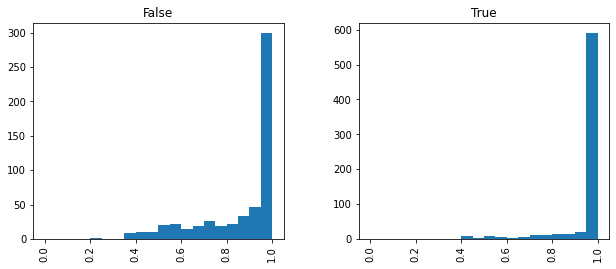

In [54]:
test_results.hist(column="1st_prob", by="correct", figsize=(10,4), range=(0,1), bins=20)

This chart shows the proportion of matches in each band of probability scores that are correct. It shows that if a cut off of 0.99 was used this would ensure a higher proportion of the results were correct. However, this would leave a number of results as un-categorized.

<AxesSubplot:ylabel='1st_prob'>

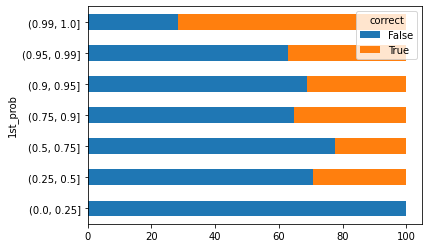

In [71]:
pd.crosstab(
    pd.cut(test_results["1st_prob"], bins=[0,0.25,0.5,0.75,0.9,0.95,0.99,1]),
    test_results["correct"],
    normalize='index'
).multiply(100).round(1).plot.barh(stacked=True)

And this table shows that using a cut-off of 0.99 would result in 39% of incorrect matches still being used, and 22% of correct matches being disgarded.

In [73]:
pd.crosstab(
    pd.cut(test_results["1st_prob"], bins=[0,0.25,0.5,0.75,0.9,0.95,0.99,1]),
    test_results["correct"],
    normalize='columns'
).multiply(100).round(1)

correct,False,True
1st_prob,,
"(0.0, 0.25]",0.2,0.0
"(0.25, 0.5]",5.3,1.7
"(0.5, 0.75]",18.4,4.2
"(0.75, 0.9]",13.3,5.8
"(0.9, 0.95]",8.4,3.0
"(0.95, 0.99]",15.5,7.2
"(0.99, 1.0]",39.0,78.0


The next two tables show a selection of results from the best (>0.9 probability) and worst (<0.9 probability) results. 

In [55]:
test_results[test_results["1st_prob"]>0.9].sample(10)

,text,manual,1st_code,1st_prob,2nd_code,2nd_prob,3rd_code,3rd_prob,correct,sector_correct
150,royal automobile club foundation motoring limi...,G22,K10,0.999340,G11,5.887123e-04,G22,3.413375e-05,False,False
467,cleverhands junior science group objective adv...,B12,K10,0.959601,B90,2.036565e-02,B21,1.374533e-02,False,False
341,coventry faith foundation aim call pure islami...,I90,I10,0.965807,I90,3.409055e-02,H90,4.706277e-05,False,True
155,topsham society promote high standard planning...,A12,A12,1.000000,G12,5.184541e-08,J20,3.299127e-08,True,True
146,gateway church abergavenny christian church pu...,I10,I10,1.000000,I90,3.503077e-07,B32,1.108210e-19,True,True
680,save child relieve distress promote welfare ch...,G30,D11,0.999780,G11,1.538995e-04,D90,2.244168e-05,False,False
324,st teresa school effingham education child wor...,B13,B13,0.999951,I90,2.782932e-05,I10,1.357951e-05,True,True
1061,magdalen college school oxford limited indepen...,B13,B13,1.000000,B32,1.229271e-17,B21,8.799637e-18,True,True
289,devon air ambulance devon air ambulance fund o...,C11,C11,1.000000,G13,4.711409e-10,D19,3.786406e-10,True,True
417,british archaeological association promote stu...,A12,A12,1.000000,B21,6.340273e-08,G12,5.620665e-08,True,True


In [59]:
test_results[test_results["1st_prob"]<=0.9].sample(10).sort_values("1st_prob", ascending=False)

,text,manual,1st_code,1st_prob,2nd_code,2nd_prob,3rd_code,3rd_prob,correct,sector_correct
172,renfrewshire model railway club objective club...,A12,F12,0.898953,G12,0.037575,A12,0.035406,False,False
355,st catherine british school teaching learning ...,B13,H10,0.877321,B32,0.122528,B10,0.000078,False,False
309,leon sterling charity purpose proportion manne...,H10,H10,0.856502,H90,0.141612,L60,0.000628,True,True
1017,2nd gretna rainbow promoting instruction girl ...,G14,B31,0.821816,G14,0.177390,H10,0.000282,False,False
706,dunard purpose dunard purpose advancement publ...,H10,H10,0.715298,F20,0.284570,A10,0.000096,True,True
206,duke edinburgh award duke edinburgh award prov...,B31,G11,0.631990,H10,0.246759,B32,0.090241,False,False
89,barton pooley bridge community make grant init...,F20,F20,0.610438,H10,0.362580,H90,0.026980,True,True
61,nysda uk nysda uk uk raise money donation gran...,D33,G11,0.578701,D33,0.329983,D19,0.062391,False,False
676,sunderland lion club promoting principle good ...,F20,F20,0.569794,G13,0.429861,H90,0.000345,True,True
63,neuroblastoma uk neuroblastoma uk raise money ...,C12,K10,0.502046,C12,0.484006,C11,0.013948,False,False


This chart compares the frequency of different categories in the actual data compared to the predicted scores, showing how some categories are over-represented.

<AxesSubplot:>

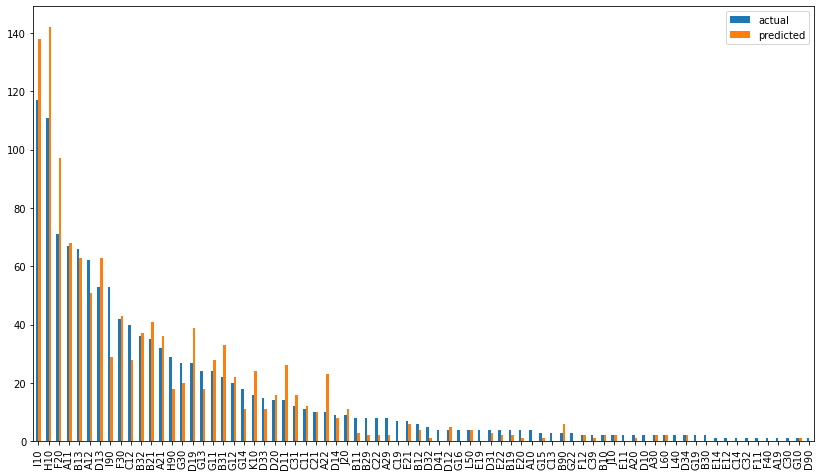

In [57]:
pd.DataFrame([
    pd.Series(y_test).value_counts().rename("actual"),
    pd.Series(y_pred).value_counts().rename("predicted"),
]).fillna(0).T.plot.bar(figsize=(14,8))